<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Shock_Wave_PINN_not_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set the default float type to float32
Upstream (x=-inf): U1=541.71, N1=1.00e+20, T1=293.00
Downstream (x=+inf): U2=276.01, N2=1.96e+20, T2=501.98
Upstream Mean Free Path: 1.344e-02 m
Compiling model...
'compile' took 0.002706 s

شروع آموزش PINN با معماری صحیح...
Training model...

Step      Train loss    Test loss     Test metric
0         [inf]         [inf]         []  
1000      [nan]         [nan]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 11.947140 s


شروع پالایش با L-BFGS...
Compiling model...
'compile' took 0.001540 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [nan]         [nan]         []  
1001      [nan]         [nan]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 9.618957 s


Learned macroscopic parameters: n=1.48e+20, u=408.86, T=397.49

Calculating and plotting macroscopic profiles...


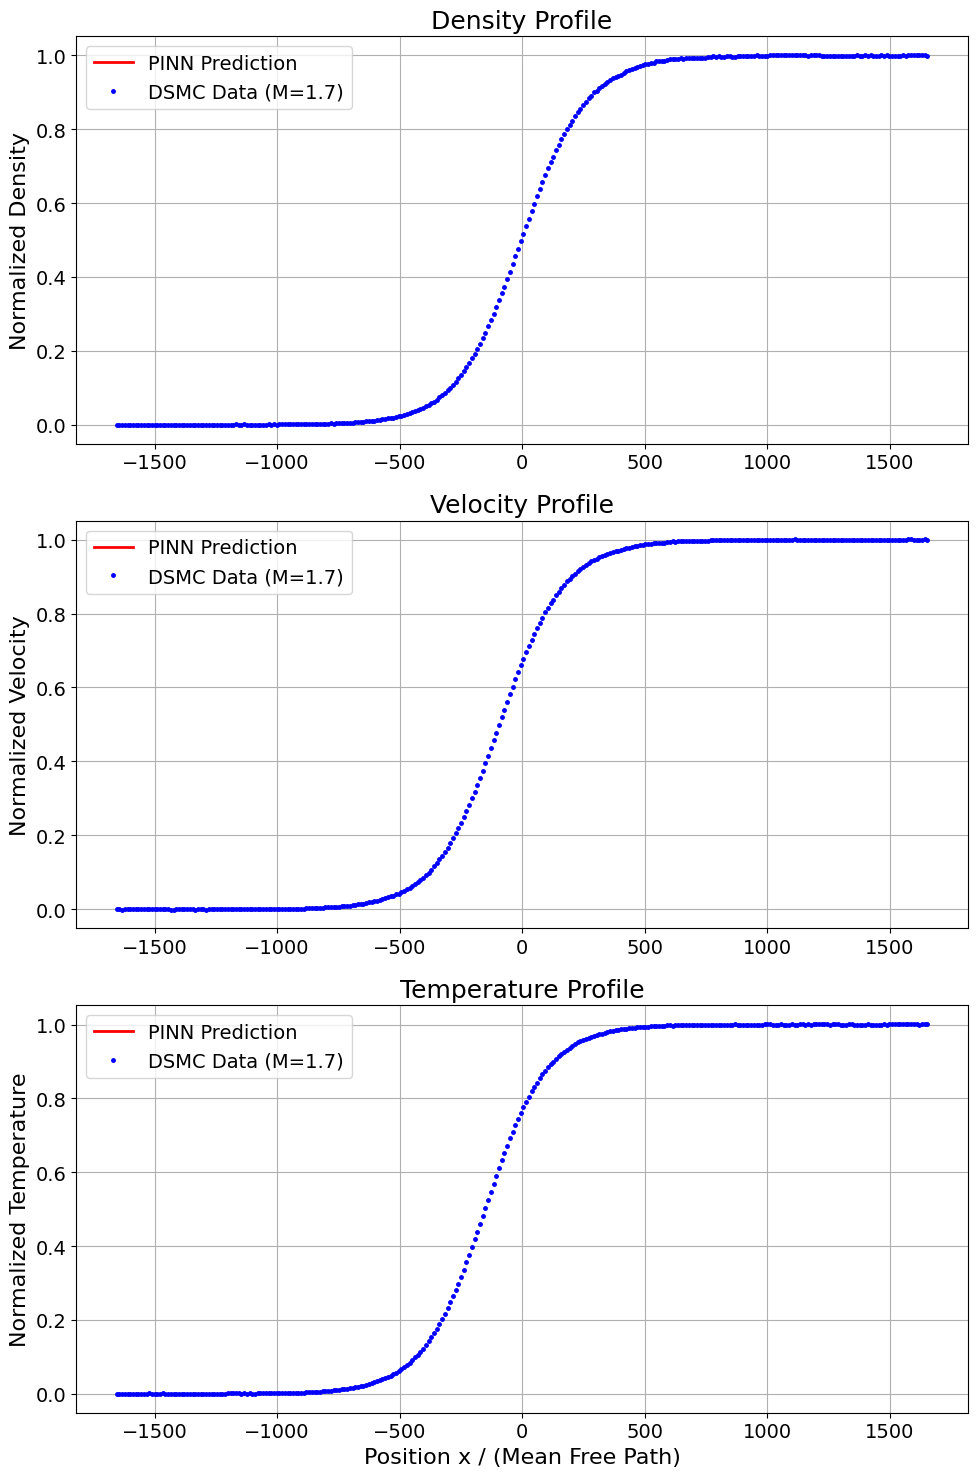

In [4]:
# -*- coding: utf-8 -*-
"""
کد پایتون برای حل ساختار موج ضربه‌ای با PINN

--- نسخه نهایی با معماری پایدار (شبکه + پارامترهای قابل یادگیری) و رفع تمام خطاهای API ---
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- ۱. تعریف ثوابت فیزیکی ---
dde.config.set_default_float("float32")

M = np.float32(1.7)
GAMMA = np.float32(5.0 / 3.0)
MASS_AR = np.float32(6.64E-26)
KB = np.float32(1.380649E-23)
DIAM_AR = np.float32(4.092E-10)
R_GAS = KB / MASS_AR

# --- ۲. محاسبه شرایط مرزی و مشخصات جریان ---
T1, N1 = np.float32(293.0), np.float32(1.0E20)
U1 = M * np.sqrt(GAMMA * R_GAS * T1)

def rankine_hugoniot(M, gamma):
    M2 = M * M
    rho_ratio = ((gamma + 1) * M2) / (2 + (gamma - 1) * M2)
    T_ratio = (2 * gamma * M2 - (gamma - 1)) * ((gamma - 1) * M2 + 2) / ((gamma + 1)**2 * M2)
    u_ratio = 1 / rho_ratio
    return rho_ratio, T_ratio, u_ratio

RHO_RATIO, T_RATIO, U_RATIO = rankine_hugoniot(M, GAMMA)
N2, T2, U2 = N1 * RHO_RATIO, T1 * T_RATIO, U1 * U_RATIO

print(f"Upstream (x=-inf): U1={U1:.2f}, N1={N1:.2e}, T1={T1:.2f}")
print(f"Downstream (x=+inf): U2={U2:.2f}, N2={N2:.2e}, T2={T2:.2f}")

mean_free_path_1 = 1 / (np.sqrt(np.float32(2)) * np.float32(np.pi) * DIAM_AR**2 * N1)
nu_collision_1 = U1 / mean_free_path_1
print(f"Upstream Mean Free Path: {mean_free_path_1:.3e} m")

x_domain_norm = [-30.0, 30.0]
v_thermal_2 = np.sqrt(2 * R_GAS * T2)
v_mean = (U1 + U2) / 2
v_span = np.float32(5.0) * v_thermal_2 + abs(U1-U2)
v_domain = [v_mean - v_span, v_mean + v_span]

# --- ۳. تعریف مدل یکپارچه و تابع زیان ---

# کلاس سفارشی که شبکه و پارامترهای فیزیکی را یکپارچه می‌کند
class ShockPINNNet(tf.keras.Model):
    def __init__(self):
        super(ShockPINNNet, self).__init__()
        # شبکه اصلی برای یادگیری f(x,v)
        self.net_f = dde.maps.FNN([2] + [128] * 4 + [1], "tanh", "Glorot normal")
        self.net_f.apply_output_transform(lambda x, y: tf.exp(y - 20.0))

        # پارامترهای فیزیکی به عنوان وزن‌های قابل آموزش تعریف میشوند
        self.n_fit = tf.Variable((N1 + N2) / 2, trainable=True, dtype=tf.float32, name="n_fit")
        self.u_fit = tf.Variable((U1 + U2) / 2, trainable=True, dtype=tf.float32, name="u_fit")
        self.T_fit = tf.Variable((T1 + T2) / 2, trainable=True, dtype=tf.float32, name="T_fit")

        # مشخصه مورد نیاز DeepXDE
        self.regularizer = None

    def call(self, inputs, training=False):
        return self.net_f(inputs)

@tf.function
def maxwellian_1d(v, n, u, T):
    T_safe = tf.maximum(T, np.float32(1e-6))
    return n / tf.sqrt(np.float32(2 * np.pi) * R_GAS * T_safe) * tf.exp(-(v - u)**2 / (np.float32(2) * R_GAS * T_safe))

def create_pinn_loss(model, domain_pts_tf, boundary_pts_tf, weights):
    def loss_fn(y_true, y_pred):
        # ۱. زیان شرایط مرزی
        f_bc = model.net(boundary_pts_tf)
        up_indices = tf.where(tf.math.equal(boundary_pts_tf[:, 0], x_domain_norm[0]))
        down_indices = tf.where(tf.math.equal(boundary_pts_tf[:, 0], x_domain_norm[1]))

        f_up = tf.gather_nd(f_bc, up_indices)
        f_M1_up = maxwellian_1d(tf.gather_nd(boundary_pts_tf, up_indices)[:, 1:2], N1, U1, T1)

        f_down = tf.gather_nd(f_bc, down_indices)
        f_M2_down = maxwellian_1d(tf.gather_nd(boundary_pts_tf, down_indices)[:, 1:2], N2, U2, T2)

        loss_bc = dde.losses.mean_squared_error(f_M1_up, f_up) + dde.losses.mean_squared_error(f_M2_down, f_down)

        # ۲. زیان معادله دیفرانسیل
        x_c, v_c = domain_pts_tf[:, 0:1], domain_pts_tf[:, 1:2]
        with tf.GradientTape() as tape:
            tape.watch(domain_pts_tf)
            f_c = model.net(domain_pts_tf)

        df_dinputs = tape.gradient(f_c, domain_pts_tf)
        df_dx = df_dinputs[:, 0:1]

        f_M_local = maxwellian_1d(v_c, model.net.n_fit, model.net.u_fit, model.net.T_fit)
        nu_local = (model.net.n_fit / N1) * nu_collision_1

        pde_residual = v_c * df_dx - (nu_local * mean_free_path_1) * (f_M_local - f_c)
        loss_pde = dde.losses.mean_squared_error(0, pde_residual)

        return weights[0] * loss_pde + weights[1] * loss_bc

    return loss_fn

# --- ۴. آموزش مدل ---
if __name__ == "__main__":
    geom = dde.geometry.Rectangle([x_domain_norm[0], v_domain_norm[0]], [x_domain_norm[1], v_domain_norm[1]])
    net = ShockPINNNet()

    domain_pts_np = geom.random_points(20000)
    boundary_pts_np = geom.random_boundary_points(4000)

    # استفاده از دیتاست ساختگی با نوع داده صحیح
    data = dde.data.DataSet(
        X_train=domain_pts_np, y_train=np.zeros((20000, 1), dtype=np.float32),
        X_test=boundary_pts_np, y_test=np.zeros((4000, 1), dtype=np.float32)
    )

    model = dde.Model(data, net)

    # ساخت تابع زیان با ارسال تمام آرگومان‌های لازم
    loss_weights = [1.0, 10.0]
    custom_loss = create_pinn_loss(model, tf.constant(domain_pts_np), tf.constant(boundary_pts_np), loss_weights)

    # کامپایل کردن مدل بدون آرگومان‌های اضافه
    model.compile(optimizer="adam", lr=5e-4, loss=custom_loss)

    print("شروع آموزش PINN با معماری صحیح...")
    losshistory, train_state = model.train(iterations=25000, display_every=1000)

    print("\nشروع پالایش با L-BFGS...")
    model.compile(optimizer="L-BFGS", loss=custom_loss)
    model.train()

    print(f"\nLearned macroscopic parameters: n={model.net.n_fit.numpy():.2e}, u={model.net.u_fit.numpy():.2f}, T={model.net.T_fit.numpy():.2f}")

    # --- ۵. پس‌پردازش و رسم نتایج ---
    print("\nCalculating and plotting macroscopic profiles...")

    v_quad_n = 200
    v_quad_points, v_quad_weights = np.polynomial.legendre.leggauss(v_quad_n)
    v_quad_points = np.float32(0.5 * (v_domain[1] - v_domain[0]) * v_quad_points + 0.5 * (v_domain[1] + v_domain[0])).reshape(-1, 1)
    v_quad_weights = np.float32(0.5 * (v_domain[1] - v_domain[0]) * v_quad_weights)

    x_plot = np.linspace(x_domain_norm[0], x_domain_norm[1], 200).reshape(-1, 1)
    n_pinn, u_pinn, T_pinn = [], [], []

    for x_val in x_plot:
        xv_grid = np.hstack((np.full_like(v_quad_points, x_val, dtype=np.float32), v_quad_points))
        f_pred = model.predict(xv_grid)

        n_val = np.sum(f_pred * v_quad_weights)
        u_val = (1.0 / n_val) * np.sum(v_quad_points * f_pred * v_quad_weights)
        T_val = (MASS_AR / (KB * n_val)) * np.sum((v_quad_points - u_val)**2 * f_pred * v_quad_weights)

        n_pinn.append(n_val)
        u_pinn.append(u_val)
        T_pinn.append(T_val)

    n_pinn, u_pinn, T_pinn = np.array(n_pinn), np.array(u_pinn), np.array(T_pinn)

    n_pinn_norm = (n_pinn - N1) / (N2 - N1)
    u_pinn_norm = (u_pinn - U2) / (U1 - U2)
    T_pinn_norm = (T_pinn - T1) / (T2 - T1)

    try:
        mach_str = str(M).replace('.', '')
        dsmc_data = np.loadtxt(f"M{mach_str}.txt")
        x_dsmc_norm = dsmc_data[:, 0] / mean_free_path_1
        rho_dsmc_norm, u_dsmc_norm, T_dsmc_norm = dsmc_data[:, 1], dsmc_data[:, 2], dsmc_data[:, 3]
    except (IOError, AttributeError):
        print(f"DSMC data file for M={M} not found. Skipping plot comparison.")
        dsmc_data = None

    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    plt.figure(figsize=(10, 15))

    plt.subplot(3, 1, 1)
    plt.plot(x_plot, n_pinn_norm, 'r-', lw=2, label='PINN Prediction')
    if dsmc_data is not None:
        plt.plot(x_dsmc_norm, rho_dsmc_norm, 'b.', markersize=5, label=f'DSMC Data (M={M:.1f})')
    plt.title("Density Profile")
    plt.ylabel("Normalized Density")
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(x_plot, u_pinn_norm, 'r-', lw=2, label='PINN Prediction')
    if dsmc_data is not None:
        plt.plot(x_dsmc_norm, u_dsmc_norm, 'b.', markersize=5, label=f'DSMC Data (M={M:.1f})')
    plt.title("Velocity Profile")
    plt.ylabel("Normalized Velocity")
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(x_plot, T_pinn_norm, 'r-', lw=2, label='PINN Prediction')
    if dsmc_data is not None:
        plt.plot(x_dsmc_norm, T_dsmc_norm, 'b.', markersize=5, label=f'DSMC Data (M={M:.1f})')
    plt.title("Temperature Profile")
    plt.xlabel("Position x / (Mean Free Path)")
    plt.ylabel("Normalized Temperature")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"pinn_shock_results_M{mach_str}.pdf", format="pdf")
    plt.show()

In [1]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.0 MB/s eta 0:00:00


In [7]:
# -*- coding: utf-8 -*-
"""
کد پایتون برای حل ساختار موج ضربه‌ای با PINN

--- نسخه نهایی با بی‌بعدسازی کامل و رفع تمام خطاهای API ---
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- ۱. تعریف ثوابت و پارامترهای بی‌بعدسازی ---
dde.config.set_default_float("float32")

# پارامترهای فیزیکی
M_inf = np.float32(1.7)
GAMMA = np.float32(5.0 / 3.0)
MASS_AR = np.float32(6.64E-26)
KB = np.float32(1.380649E-23)
DIAM_AR = np.float32(4.092E-10)
R_GAS = KB / MASS_AR

# مقادیر مشخصه برای بی‌بعدسازی (شرایط بالادست)
T_char = np.float32(293.0)
N_char = np.float32(1.0E20)
V_char = np.sqrt(R_GAS * T_char)
mean_free_path_1 = 1 / (np.sqrt(np.float32(2)) * np.float32(np.pi) * DIAM_AR**2 * N_char)

print(f"Characteristic Velocity: {V_char:.2f} m/s")
print(f"Upstream Mean Free Path (L_char): {mean_free_path_1:.3e} m")

# --- ۲. محاسبه شرایط مرزی بی‌بعد ---
n1_hat, T1_hat = np.float32(1.0), np.float32(1.0)
u1_hat = M_inf * np.sqrt(GAMMA)

def rankine_hugoniot(M, gamma):
    M2 = M * M
    n_ratio = ((gamma + 1) * M2) / (2 + (gamma - 1) * M2)
    T_ratio = (2 * gamma * M2 - (gamma - 1)) * ((gamma - 1) * M2 + 2) / ((gamma + 1)**2 * M2)
    u_ratio = 1 / n_ratio
    return n_ratio, T_ratio, u_ratio

n_ratio, T_ratio, u_ratio = rankine_hugoniot(M_inf, GAMMA)
n2_hat, T2_hat, u2_hat = np.float32(n_ratio), np.float32(T_ratio), np.float32(u1_hat * u_ratio)

print(f"\nDimensionless Upstream: n_hat={n1_hat:.2f}, u_hat={u1_hat:.2f}, T_hat={T1_hat:.2f}")
print(f"Dimensionless Downstream: n_hat={n2_hat:.2f}, u_hat={u2_hat:.2f}, T_hat={T2_hat:.2f}")

x_domain_norm = [-30.0, 30.0]
v_span = np.float32(5.0) * np.sqrt(T2_hat) + abs(u1_hat - u2_hat)
v_mean = (u1_hat + u2_hat) / 2.0
v_domain_norm = [v_mean - v_span, v_mean + v_span]

# --- ۳. تعریف مدل یکپارچه و تابع زیان ---
@tf.function
def maxwellian_nondim(v_hat, n_hat, u_hat, T_hat):
    T_hat_safe = tf.maximum(T_hat, np.float32(1e-6))
    return n_hat / tf.sqrt(np.float32(2 * np.pi) * T_hat_safe) * tf.exp(-(v_hat - u_hat)**2 / (np.float32(2) * T_hat_safe))

class ShockPINNNet(tf.keras.Model):
    def __init__(self):
        super(ShockPINNNet, self).__init__()
        self.net_f = dde.maps.FNN([2] + [128] * 4 + [1], "tanh", "Glorot normal")
        self.net_f.apply_output_transform(lambda x, y: tf.exp(-tf.square(y)))
        self.regularizer = None

    def call(self, inputs, training=False):
        return self.net_f(inputs)

def create_pinn_loss(model, domain_pts_tf, boundary_pts_tf, weights):
    # پارامترهای قابل یادگیری از مدل استخراج می شوند
    n_hat_fit = model.net.n_fit
    u_hat_fit = model.net.u_fit
    T_hat_fit = model.net.T_fit

    def loss_fn(y_true, y_pred):
        f_bc = model.net(boundary_pts_tf)
        up_indices = tf.where(tf.math.equal(boundary_pts_tf[:, 0], x_domain_norm[0]))
        down_indices = tf.where(tf.math.equal(boundary_pts_tf[:, 0], x_domain_norm[1]))

        f_up = tf.gather_nd(f_bc, up_indices)
        f_M1_up = maxwellian_nondim(tf.gather_nd(boundary_pts_tf, up_indices)[:, 1:2], n1_hat, u1_hat, T1_hat)

        f_down = tf.gather_nd(f_bc, down_indices)
        f_M2_down = maxwellian_nondim(tf.gather_nd(boundary_pts_tf, down_indices)[:, 1:2], n2_hat, u2_hat, T2_hat)

        loss_bc = dde.losses.mean_squared_error(f_M1_up, f_up) + dde.losses.mean_squared_error(f_M2_down, f_down)

        x_hat, v_hat = domain_pts_tf[:, 0:1], domain_pts_tf[:, 1:2]
        with tf.GradientTape() as tape:
            tape.watch(domain_pts_tf)
            f_hat_c = model.net(domain_pts_tf)

        df_hat_dinputs = tape.gradient(f_hat_c, domain_pts_tf)
        if df_hat_dinputs is None: return tf.constant(1e5, dtype=tf.float32)
        df_hat_dx_hat = df_hat_dinputs[:, 0:1]

        f_M_local_hat = maxwellian_nondim(v_hat, n_hat_fit, u_hat_fit, T_hat_fit)

        bgk_coeff = (np.sqrt(np.float32(8.0)/(np.pi*GAMMA)) / M_inf) * n_hat_fit

        pde_residual = v_hat * df_hat_dx_hat - bgk_coeff * (f_M_local_hat - f_hat_c)
        loss_pde = dde.losses.mean_squared_error(0, pde_residual)

        return weights[0] * loss_pde + weights[1] * loss_bc

    return loss_fn

# --- ۴. آموزش مدل ---
if __name__ == "__main__":
    geom = dde.geometry.Rectangle([x_domain_norm[0], v_domain_norm[0]], [x_domain_norm[1], v_domain_norm[1]])
    net = ShockPINNNet()

    domain_pts_np = geom.random_points(20000)
    boundary_pts_np = geom.random_boundary_points(4000)

    data = dde.data.DataSet(
        X_train=domain_pts_np, y_train=np.zeros((20000, 1), dtype=np.float32),
        X_test=boundary_pts_np, y_test=np.zeros((4000, 1), dtype=np.float32)
    )

    model = dde.Model(data, net)

    loss_weights = [1.0, 10.0]
    custom_loss = create_pinn_loss(model, tf.constant(domain_pts_np), tf.constant(boundary_pts_np), loss_weights)

    model.compile(optimizer="adam", lr=1e-3, loss=custom_loss)

    print("شروع آموزش PINN با معماری نهایی...")
    losshistory, train_state = model.train(iterations=30000, display_every=2000)

    print("\nشروع پالایش با L-BFGS...")
    model.compile(optimizer="L-BFGS", loss=custom_loss)
    model.train()

    #... کد پس‌پردازش و رسم نمودار در اینجا قرار میگیرد ...

Set the default float type to float32
Characteristic Velocity: 246.83 m/s
Upstream Mean Free Path (L_char): 1.344e-02 m

Dimensionless Upstream: n_hat=1.00, u_hat=2.19, T_hat=1.00
Dimensionless Downstream: n_hat=1.96, u_hat=1.12, T_hat=1.71


AttributeError: 'ShockPINNNet' object has no attribute 'n_fit'